# notebook to analyze LDA output (tagged paragraphs)

In [1]:
import re
import spacy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from gensim.matutils import hellinger
from urllib.request import urlopen
import matplotlib.pyplot as plt

In [36]:
baha = pd.read_json('../data/FINAL_TAGGED_PARS_BAHA.json')

### plot topics by day

In [37]:
ordered_labels = baha.groupby('topic_str').size().sort_values(ascending=False)

In [38]:
rng = pd.date_range('09-01-2019', '10-01-2019')
dates = rng.to_pydatetime()
idx = [date.strftime('%Y-%m-%d') for date in dates]

def barplot_(label):
    s = baha[baha.topic_str == label].groupby('date').size()
    s = s.reindex(rng, fill_value=0)
    return s

In [39]:
ordered_labels

topic_str
School            12109
Aid               11120
Bahamas           10655
US Impact         10296
Family            10110
Weather            7635
US Politics        5431
US Immigration     1993
Tourism            1475
Climate             796
Cruise              763
Boilerplate         607
dtype: int64

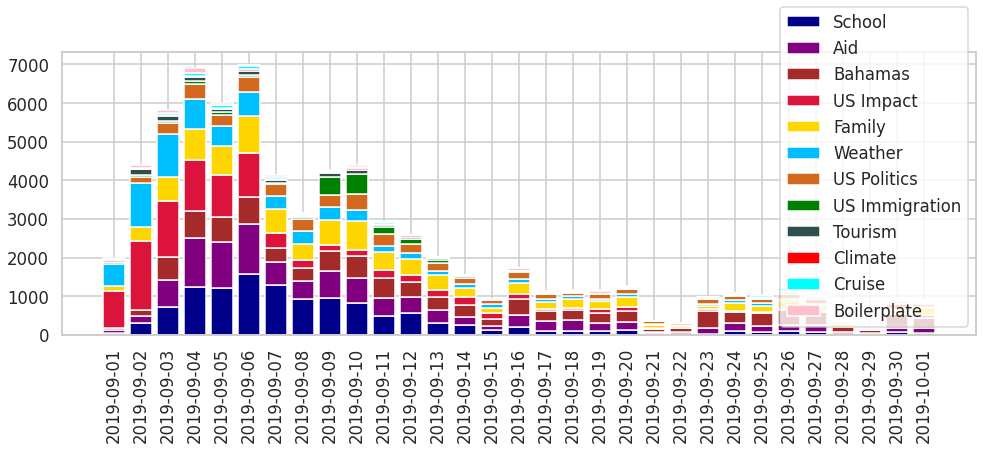

In [41]:
sns.set(style='whitegrid')
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(14,6))

labels_ = [lab for lab in ordered_labels.index]
colors = ['darkblue', 'purple', 'brown', 'crimson', 'gold', 'deepskyblue', 'chocolate', 'green',
          'darkslategrey', 'red', 'cyan', 'pink']
colordict = dict(zip(labels_, colors))

labels = [l for l in ordered_labels.index]

series = []
series_ = pd.Series(len(rng)*[0], rng)
bottoms = [series_]

for l in labels:
    s = barplot_(l)
    series.append(s)
    series_ = series_.add(s)
    bottoms.append(series_)

for s, b, label in zip(series, bottoms[:-1], labels):
    plt.bar(idx, s, bottom=b, color=colordict[label])

plt.xticks(idx, rotation='vertical')
plt.legend(labels=labels)
plt.tight_layout()
plt.savefig('../plots/FINAL_TOPICS_PARS_BAHA.png')
plt.show()

### compute Hellinger distance between days

In [42]:
sseries = [s.rename(l) for s, l in zip(series, labels)]

topic_matrix = pd.concat(sseries, axis=1)

In [43]:
topic_mat_norm = topic_matrix.div(topic_matrix.sum(axis=1), axis=0)

In [44]:
rows = [row.values for i,row in topic_mat_norm.iterrows()]

In [ ]:
hellinger_scores = [hellinger(row_1, row_2) for row_1, row_2 in zip(rows[1:], rows)]

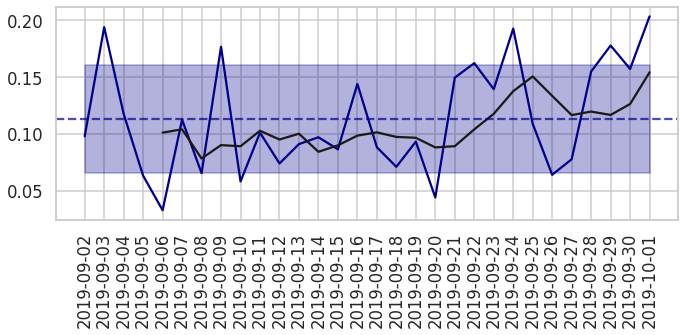

In [46]:
sns.set(style='whitegrid')
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(idx[1:], hellinger_scores, color='darkblue')
plt.fill_between(range(len(idx[:-1])), np.mean(hellinger_scores)+np.std(hellinger_scores),
                      np.mean(hellinger_scores)-np.std(hellinger_scores), color='darkblue', alpha=.3)
plt.plot(range(len(idx[:-1])), pd.Series(hellinger_scores).rolling(5).mean(), color='k')
plt.axhline(np.mean(hellinger_scores), ls='--', color='darkblue', alpha=.7)
plt.xticks(idx[1:], rotation='vertical')
plt.tight_layout()
plt.savefig('../plots/FINAL_HELL_PARS_BAHA.png')
plt.show()

In [47]:
import numpy as np
np.mean(hellinger_scores), np.std(hellinger_scores)

(0.11323780737838214, 0.04732400344466704)

### Hellinger matrix

In [48]:
hellinger_rows = []
for row1 in rows:
    hellingers = []
    for row2 in rows:
        hellingers.append(hellinger(row1, row2))
    hellinger_rows.append(hellingers)

In [49]:
hellinger_matrix = pd.DataFrame(dict(zip(idx, hellinger_rows)))

In [50]:
np.mean(hellinger_matrix.values), np.std(hellinger_matrix.values)

(0.23856996002693817, 0.12476227606607677)